In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import PIL
import os
import numpy as np
from tqdm.notebook import tqdm

from prg.networks import Generator, Discriminator

# Data

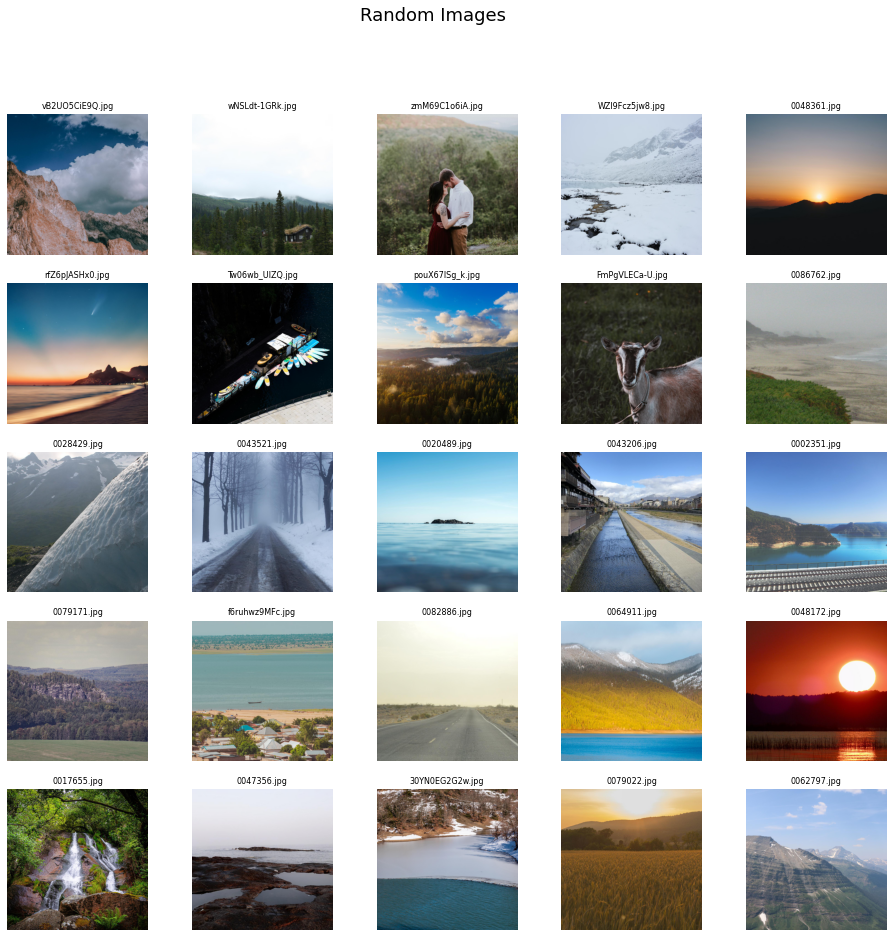

In [21]:
N_IMAGES = 25
SEED = 11

np.random.seed(SEED)
random_images = np.random.choice(os.listdir('./data/images'), size=N_IMAGES, replace=False)
ncols = 5
nrows = N_IMAGES // ncols
fig = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3*nrows))

plt.suptitle('Random Images', fontsize=18)

for i, img in enumerate(random_images):
    plt.subplot(nrows, ncols, i+1)
    image = PIL.Image.open('./data/images/' + img)
    plt.imshow(image)
    plt.title(img, fontsize=8)
    plt.axis('off')
    
plt.show()

**Beschreibung:**

Die Beispielbilder zeigen, dass die Bilder meistes aus Landschaftsbilder bestehen. Es gibt jedoch auch Bilder die bspw. Tiere oder auch Menschen enthalten. Dies könnte durchaus ein Problem werden bei der Erzeugung der Bilder. Die Hoffnung besteht jedoch darin, dass dies den Output nicht stark beeinflussen wird, da der Anteil solcher Bilder sehr klein ist.

In [ ]:
# Params 
BATCH_SIZE = 32
WORKERS = 8
IMAGE_ROOT = './data'

In [2]:
dataset = ImageFolder(root=IMAGE_ROOT,
                      transform=transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), 
                                                                                 (0.5, 0.5, 0.5))]))
dataloader = DataLoader(dataset, 
                        batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=WORKERS)
# Plot some training images
real_batch = next(iter(dataloader))

NameError: name 'ImageFolder' is not defined

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# DCGAN - Deep Convolutional Generative Adversial Network

[<img src="./doc/dcgan_generator.png" width="500"/>](image.png)

- Im Generator müssen eventuell die Strides erhöht werden falls Checkerboard-Effekt auftritt bei den Output Bildern.

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):   
    """
    This class implements a Generator inspired by DCGAN.
    Uses Fractionally Strided Convolutions to ensure that the training learns it own upsampling layers.
    Additionally ReLu activations are applied between each layer + Batchnorm for more stable training. 
    In the output Layer one can find a tanh-Activation.
    """
    
    def __init__(self, z_dim):
        """
        Implementation of Generator with aspects from the paper which introduced DCGAN (Deep Convolutional GAN's)
        
        params:
        -----------
        z_dim: (int)
            Dimensionality of the Latent Vector
        """
        super().__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            # Input Latent Vector
            nn.ConvTranspose2d(in_channels=self.z_dim, out_channels=1024, 
                               kernel_size=(4, 4), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(inplace=True),
            # 4x4
            # Adjustment of this layer stride of 4 -> 16x16 out
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, 
                               kernel_size=(4, 4), stride=4, padding=0, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            # 16x16
            nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                               kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            # output Size = 32
            nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                               kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            # output Size = 64
            nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                               kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            # output Size = 128
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                               kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            # output Size = 256
            nn.ConvTranspose2d(in_channels=32, out_channels=16, 
                               kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
            # output Size = 512
            nn.ConvTranspose2d(in_channels=16, out_channels=3, 
                               kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.Tanh(),
            # Out = 1024
        )

    def forward(self, input):
        return self.gen(input)
    
class Discriminator(nn.Module):
    """
    This class implements the Discriminator inspired by the DCGAN. 
    Uses LeakyRelu und Sigmoid activation in the end as well as Batchnorm bt. each layer for a more stable training.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input 1024x1024 per channel
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 512x512
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            # 256x256
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # 128x128
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64x64
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 32x32
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            #16x16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            #8x8
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            #4x4
            nn.Conv2d(64, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Resulting in one output neuron for BCE-Loss
        )

    def forward(self, input):
        return self.main(input)

In [8]:
z_vec = torch.rand(64,100,1,1)
print('Z-Vector:', z_vec.shape)

Z-Vector: torch.Size([64, 100, 1, 1])


In [11]:
# Test Generator
generator = Generator(z_dim=z_vec.shape[1])
out = generator(z_vec)
assert out.shape == torch.Size([64, 3, 1024, 1024])
print('--- Test Passed ---')

--- Test Passed ---


In [12]:
# Test Discrimnator
sample_image = torch.rand((3, 1024, 1024))
sample_image = sample_image.unsqueeze(0)
discriminator = Discriminator()
out = discriminator(sample_image)
assert out.shape == torch.Size([1, 1, 1, 1])
print('--- Test Passed ---')

--- Test Passed ---


# Sources

https://arxiv.org/pdf/1511.06434.pdf

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html